# PCA predictions using logistic regression
to show that the added genetic data does not add much to the PCA we need to apply regression on the PCA values to the phenotype and show that the explenability is not too good

perform analysis on phenotypes produced with:
* 0%/10%/30%/50%/70% weight PCA
* 0%/10%/30%/50%/70% heretability

In [1]:
import pandas as pd
import os
import glob
import re
import re
import statsmodels.api as sm
import datetime


In [2]:
import numpy as np
import matplotlib.pyplot as plt


In [3]:
GENETICS_PATH = "/sci/nosnap/michall/roeizucker/covar_tests/small_genetics"
COVARS_PATH = "/sci/archive/michall/roeizucker/covar_tests_non_coding_HADASSA_PLINK"
PLINK_PATH = "/sci/nosnap/michall/roeizucker/plink2"
TEST_COVAR = "covariates_sex_year_of_birth_AC_batch_40_PC.txt"
COVAR_DF_PREFIX = "temp_covar_df"
VERSION = "multi_effect_score_0.10"
EXTRA_PHEN = "/sci/archive/michall/roeizucker/covar_tests_non_coding_HADASSA_PLINK/phenotypes/hypertension.txt"

# RELATIVE_EFFECT_OF_PC =  0.7347749803596619
# TODO: try to add load json for parameters

In [4]:
covar_df = pd.read_csv(os.path.join(COVARS_PATH,TEST_COVAR),sep="\t",header=None)

In [5]:
import pandas as pd
import glob
import re

# Define the file pattern to match your CSV files.
file_pattern = "temp_covar_df_v=multi_effect_score_*_her=*_cov=*.csv"
file_list = glob.glob(file_pattern)

# Compile a regular expression to extract the numbers from the filename.
pattern = re.compile(
    r"temp_covar_df_v=multi_effect_score_([0-9\.]+)_her=([0-9\.]+)_cov=([0-9\.]+)\.csv"
)

# Dictionary to store DataFrames keyed by (multi_effect_score, her, cov)
dfs = {}

# Loop over each file in the list
for filename in file_list:
    match = pattern.search(filename)
    if match:
        # Extract the numeric values and convert them to floats.
        multi_effect_score = float(match.group(1))
        her = float(match.group(2))
        cov = float(match.group(3))
    else:
        print(f"Filename {filename} did not match the expected pattern.")
        continue  # Skip files that do not match the pattern

    # Read the CSV file into a DataFrame.
    df = pd.read_csv(filename)

    # (Optional) Add columns with the extracted parameter values.
    df["multi_effect_score"] = multi_effect_score
    df["her"] = her
    df["cov"] = cov

    # Use a tuple of parameters as the dictionary key.
    key = (multi_effect_score, her, cov)
    dfs[key] = df

# Example usage: Access the DataFrame for a specific set of parameter values.
# example_key = (0.1, 0.1, 0.1)
# if example_key in dfs:
#     print(f"DataFrame for parameters {example_key}:")
#     print(dfs[example_key].head())
# else:
#     print(f"No DataFrame found for parameters {example_key}")


In [7]:
regression_results = {}

# Loop over each DataFrame in the dictionary.
for key, df in dfs.items():
    multi_effect_score, her, cov = key
    # Check if her + cov is less than 1.
    if her + cov <= 1:
        # print(key)
        
        # Define predictor column names: PC1, PC2, ..., PC40.
        pc_columns = [f"PC{i}" for i in range(1, 41)]
        # Extract predictors (X) and response (Y).
        temp_df = df.dropna()
        if EXTRA_PHEN:
            extra_phen_df = pd.read_csv(EXTRA_PHEN,sep="\t",header=None, names=["iid","fid","phen"])
            extra_phen_df = extra_phen_df.set_index("iid")
            temp_df = temp_df.set_index("iid")
            temp_df["disease_indicator"] = extra_phen_df["phen"] - 1
            temp_df = temp_df.reset_index()
        X = temp_df[pc_columns]
        y = temp_df["disease_indicator"]

        # Add an intercept (constant) to the model.
        X = sm.add_constant(X)

        # Fit the linear regression model.
        model = sm.OLS(y, X).fit()

        # Store the fitted model in the results dictionary.
        regression_results[key] = model
# Example: Present the regression summary for each file that met the condition.


In [8]:
temp_df

,iid,Unnamed: 0,fid,sex,year_of_birth,AC_stockport_pilot,AC_manchester,AC_oxford,AC_cardiff,AC_glasgow,...,PC38,PC39,PC40,covar_effects_chance,genetic_chance,disease_chance,disease_indicator,multi_effect_score,her,cov
0,5895328,0,5895328,1.0,-1.152223,0.0,0.0,1.0,0.0,0.0,...,-2.041770,-0.329472,-0.610231,-0.650187,-0.200271,-1.924548,0.0,0.1,0.1,0.2
1,5764375,1,5764375,0.0,-0.024885,0.0,0.0,1.0,0.0,0.0,...,-1.723410,-0.140920,1.834630,-0.286593,0.280044,0.424001,0.0,0.1,0.1,0.2
2,5503073,2,5503073,1.0,-0.901703,0.0,0.0,0.0,1.0,0.0,...,-1.714340,4.746740,-0.425447,0.497159,0.159965,-1.249535,1.0,0.1,0.1,0.2
3,2563626,3,2563626,1.0,-0.150145,0.0,0.0,0.0,0.0,0.0,...,-2.507100,-2.025750,7.023560,-0.161428,-0.040166,-0.945895,1.0,0.1,0.1,0.2
4,4980832,4,4980832,1.0,-0.400665,0.0,0.0,0.0,0.0,0.0,...,-2.291620,-2.461820,-3.445180,0.217618,-0.360376,0.310634,0.0,0.1,0.1,0.2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
332640,2243883,333366,2243883,1.0,-0.275405,0.0,1.0,0.0,0.0,0.0,...,-0.533189,-0.582788,0.070181,0.009551,-0.200271,0.724001,1.0,0.1,0.1,0.2
332641,3570729,333367,3570729,1.0,0.476153,0.0,0.0,0.0,0.0,0.0,...,-0.671792,2.334690,-3.509470,0.556593,0.159965,-0.212996,0.0,0.1,0.1,0.2
332642,1663456,333368,1663456,1.0,-1.277482,0.0,0.0,0.0,0.0,0.0,...,-3.719140,-1.817060,0.452773,0.299877,0.119939,1.156461,0.0,0.1,0.1,0.2
332643,3118989,333369,3118989,0.0,-1.152223,0.0,0.0,0.0,0.0,0.0,...,-2.201190,-0.167185,-0.494174,0.144503,0.039886,-0.362839,1.0,0.1,0.1,0.2


In [7]:
# for params, model in regression_results.items():
#     print(f"\nRegression results for parameters (multi_effect_score, her, cov) = {params}:\n")
#     print(model.summary())
#     # break


In [8]:
results = []
columns = ["ver","her","cov","r_sq",'const'] + ["PC" + str(i) for i in range(1,41)] 
for params, model in regression_results.items():
    # if params[0] == 0.2 and params[1] == 0.7:
    # print(f"For parameters (ver, her, cov) = {params}:")
    # print(f"R-squared: {model.rsquared:.3f}")
    # print(f"expected effect: {(RELATIVE_EFFECT_OF_PC * params[2])**2:.6f}")
    # print(model.params)
    ver = params[0]
    her = params[1]
    cov = params[2]
    r_sq = model.rsquared
    coefs = list(model.params)
    
    values = [ver,her,cov,r_sq] + coefs
    results.append(values)
    # print(dir(model))

In [9]:
df = pd.DataFrame(results,columns=columns)

x = str(datetime.datetime.now())
if not EXTRA_PHEN:
    df.to_csv(f"regression_results_{VERSION}_{x}.csv")
else:
    df.to_csv(f"regression_results_{VERSION}_{x}_extra_phen.csv")

In [10]:
f"regression_results_{VERSION}_{x}.csv"

'regression_results_multi_effect_score_0.10_2025-02-09 11:26:36.378105.csv'

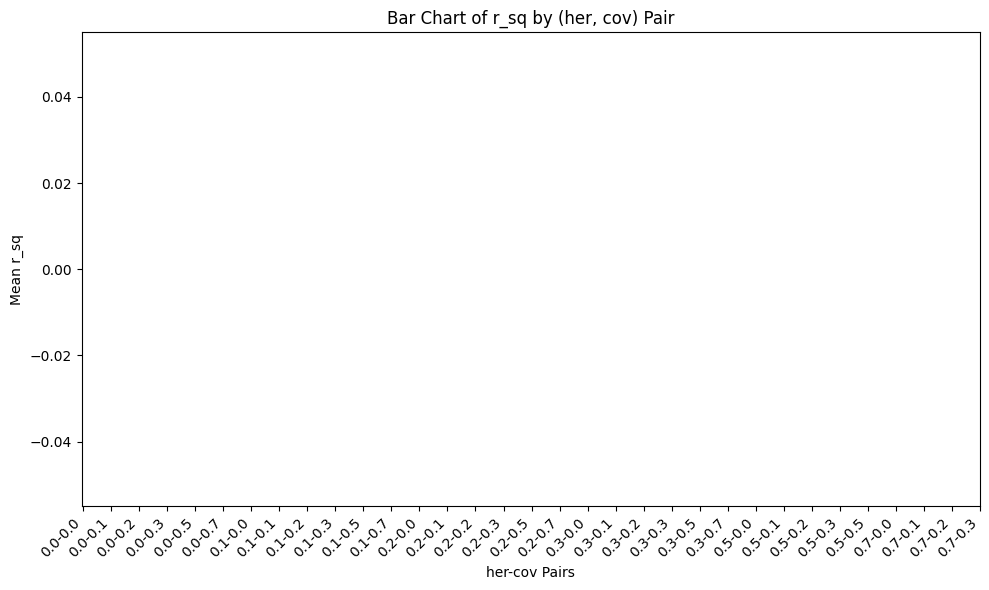

In [11]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

# df has columns ["her", "cov", "r_sq"]

# 1) Group by (her, cov) to get mean r_sq
grouped = df.groupby(["her", "cov"])["r_sq"].mean().reset_index()

# 2) Build an x-axis of pairs
#    We'll create a label like "herX-covY"
grouped["pair_label"] = grouped.apply(lambda row: f'{row["her"]}-{row["cov"]}', axis=1)

labels = grouped["pair_label"]
x_positions = np.arange(len(labels))
r_sq_values = grouped["r_sq"]

# 3) Plot
plt.figure(figsize=(10, 6))
plt.bar(x_positions, r_sq_values, color="skyblue")

# 4) Label the x-axis with the pair labels
plt.xticks(x_positions, labels, rotation=45, ha="right")

plt.xlabel("her-cov Pairs")
plt.ylabel("Mean r_sq")
plt.title("Bar Chart of r_sq by (her, cov) Pair")
plt.tight_layout()
plt.show()


In [12]:
# import matplotlib.pyplot as plt

# # We get the unique covar_types in sorted order
# unique_covars = sorted(res_df["covar_type"].unique())

# # For each covar_type, collect the found_overall values as a list
# data_for_boxplot = [
#     res_df.loc[res_df["covar_type"] == cov, "lambda"].dropna().values
#     for cov in unique_covars
# ]

# plt.figure(figsize=(8, 6))
# plt.boxplot(data_for_boxplot, labels=unique_covars, showmeans=True)
# plt.xticks(rotation=45, ha="right")
# plt.ylabel(DESIERED_PARAMETER)
# plt.title(f"Distribution of lambda by Covariate Type")
# plt.tight_layout()
# plt.show()


In [13]:
versions = [0.5]
COVARIATE_SCORES = [0,0.1,0.2,0.3,0.5,0.7]
for ver in versions:
    for cov in COVARIATE_SCORES:
        print("ver",ver,"cov",cov,"mean_rseq",df[(df["ver"] == ver) & (df["cov"] == cov)]["r_sq"].mean())

ver 0.5 cov 0 mean_rseq nan
ver 0.5 cov 0.1 mean_rseq nan
ver 0.5 cov 0.2 mean_rseq nan
ver 0.5 cov 0.3 mean_rseq nan
ver 0.5 cov 0.5 mean_rseq nan
ver 0.5 cov 0.7 mean_rseq nan


In [14]:
conf_matrix = df.groupby(['ver', 'cov'])['r_sq'].mean().unstack('cov')
print(conf_matrix)

cov  0.0  0.1  0.2  0.3  0.5  0.7
ver                              
0.1  NaN  NaN  NaN  NaN  NaN  NaN


In [15]:
df

,ver,her,cov,r_sq,const,PC1,PC2,PC3,PC4,PC5,...,PC31,PC32,PC33,PC34,PC35,PC36,PC37,PC38,PC39,PC40
0,0.1,0.3,0.1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,0.1,0.0,0.1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,0.1,0.1,0.5,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,0.1,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,0.1,0.7,0.2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5,0.1,0.3,0.3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
6,0.1,0.2,0.3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
7,0.1,0.7,0.3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
8,0.1,0.3,0.7,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
9,0.1,0.5,0.3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
